# Implémentation d'un "Spatial Broadcast Beta-Variational Autoencoder"

## Introduction

Dans le cadre de mon stage, une deuxième partie de mon projet consistait à implémenter un β-variational-autoencoder sur les images précédemment générées grâce au logiciel Blender (c.f document "space_visualisation.ipynb" ). Ce modèle a été implémenté en utilisant différentes techniques expliquées dans certains articles spécifiques afin d'obtenir un espace latent que l'on qualifie de "désenmélé". Ces techniques ont consistées à ajouter une valeur de pondération dans la perte utilisées lors de la backpropagation pour l'apprentissage du réseau, appelé β. Ajouter ce terme à la fonction de perte implique accorder d'avantage de poids à ordonner les données de façon pertinentes dans l'espace latent qu'à la reconstruction même de l'image d'entrée. Ainsi, il est nécessaire de trouver une valeur de β qui favorise à la fois une bonne reconstruction ainsi que des données "démélées" dans l'espace latent. Nous reviendront plus tard dans ce document sur l'impact de β pour l'apprentissage du réseau. Nous avons également utilisée la technique du "spatial broadcasting" consistant à ajouter des informations spatiales non supervisées au décodeur. Nous reviendront également sur ce point. Ainsi, nous avons effectué différents apprentissage de ce réseau sur le même jeu de données en faisant varier les valeurs de β. Cela nous a permis, par la suite, de vérifier le démélage de l'espace latent (c.f. document "latent_space.ipynb"). 

Ce présent Notebook est également associé à plusieurs scripts python ("dataset.py", "variationalAutoEncoder.py" et "training.py" ) qui nous ont permis d'obtenir le résultat final. 

## Explication de l'Auto-Encodeur

Afin de comprendre le beta-variationa-autoencoder, nous allons dans un premier temps expliquer succintement le fonctionement d'un autoencodeur ainsi que voir les différentes architectures d'un tel réseau. 

Un Autoencodeur est un type spécifique d'architecture de réseau de neurones, dans lequel on souhaite que l'entrée du réseau soit équivalente à sa sortie. Le but de l'encodeur est de compresser les données d'entrées de façon pertinente vers un espace à dimension différent (plus petit que l'entrée ou supérieur), et par la suite le décodeur créé une représentations de ces compressions en les reprojetant dans l'espace initial. 
Afin d'effectuer cela, l'autoencoder est composé de trois composants principal : un encodeur, les données d'entrées transformées communément appelé espace latent, et un décodeur. L'idée générale des autoencodeurs consiste à implémenter deux architectures de réseaux de neurones, un encodeur et un décodeur, qui permettent d'apprendre le meilleur schéma d'encodage-décodage en utilisant un procédé d'optimisation itératif. A chaque itérations, l'architecture de l'autoencodeur est nourrie par les données d'entrées, on compare ces données encodées-décodées avec les données initiales puis on rétropropage l'erreur à travers l'architecture pour mettre à jour les poids du réseau.

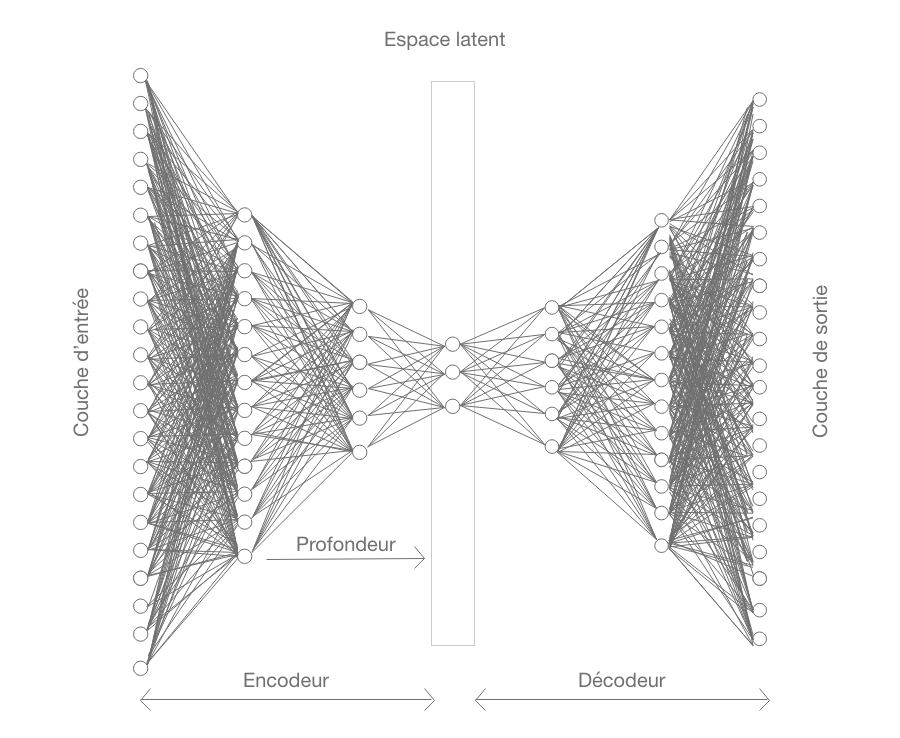

In [1]:
from PIL import Image       
from pathlib import Path
# to load images
from IPython.display import display 
path_absolute = Path().absolute()
pil_im = Image.open(str(path_absolute)+'/img/AUTOENCODEUR.png')
display(pil_im)

_Schéma d'un AutoEncodeur_  

Les autoencodeurs ont certaines spécificités importantes. Premièrement, ils sont capables de reconstuire des données de sorties relativement similaires au données d'entrées. Néanmoins, de par la compression effectuée, une certaine dégradation de ces données est à prévoir. Finalement, les autoencodeurs s'entraînent de façon "non supervisée" : cela signifique que l'on ne leur fournit pas de labels spécifiques lors de l'entraînement pour la reconstruction. Ils génèrent par eux mêmes ces labels à partir des données d'entrées. On appelle également cela une technique d'entraînement "auto-supervisés". Contraindre l'espace latent à avoir une taille significativement inférieure à celle de l'espace d'origine permet de nous assurer que l'autoencodeur, à travers l'entraînement, soit capable de créer une représentation latente composée uniquement de propriétés pertinentes.

Concernant l'architecture, l'encodeur peut être considéré comme une fonction d'encodage $f(x)=h$ où $h$ représente l'espace latent, et le décodeur comme une fonction de décodage $g(h)= x̂$ où x̂ représente l'image reconstruire. Il est pertinent de savoir qu'il existe différentes architecture d'autoencodeur : lorsque nos données d'entrées consistent en des vecteurs plats en une dimension, il est possible d'utiliser un réseau de neurones séquentiel dense ( dans le cas du Vanilla Autoencodeur ou du Multilayer Autoencodeur par exemple ) afin d'encoder et de décoder nos données. Dans le cas de ce document, allons discuter de la forme que prennent l'encodeur et le décodeur dans le cas où les données sont des images (soient des matrices) à la place de vecteurs d'une seule dimension. Dans ce cas, il est pertinent d'implémenter un "convolutional autoencoder", dans lequel l'image est sous échantillonnée afin d'obtenir une représentation latente de dimension inférieure à travers différentes couches de convolution, forçant ainsi l'autoencodeur à apprendre une version compressée de l'image. Le décodeur, quant à lui, décompresse les images à travers des déconvolutions jusqu'à obtenir une matrice de la même taille que les données d'entrées.

- Les couches de convolutions de l'encodeur

Le réseau de neurones à convolutions constituant l'encodeur, éagelement appelée CNN ("Convolutional Neural Network") est un type de réseau de neurones denses dont le motif de connexion entre chaque neurone s'insprie du cortex visuel chez les animaux. Le but de chaque neurone, dont le fonctionnement s'inspire de différents processus biologiques, est de pré-traiter de petites quantités d'informations. Concrêtement sur une image, un filtre (correspondant à une matrice de valeurs) permet de faire ressortir certaines caractéristiques d'une image : en étant déplacé tout au long de l'image et en effectuant une convolution entre l'image et le filtre, chaque nouvelle valeur est inferée vers une nouvelle matrice. Pour chaque couche de convolution de l'encodeur, il est nécessaire de spécifier la taille du filtre (généralement 3 * 3), le nombre de filtres par couche et le pas par lequel il est translaté sur les données de la couche précédente. 

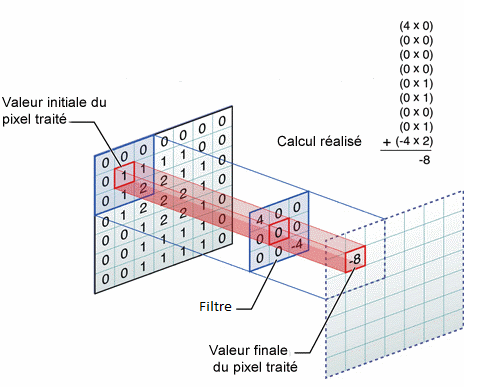

In [9]:
pil_im = Image.open(str(path_absolute)+'/img/conv.png')
display(pil_im)

Afin de réduire la taille de l'espace dans lequel se trouvent les données, une couche de pooling est effectuée (généralement technique de Max Pooling), consistant à réduire la taille de l'image en gardant uniquement les valeurs précisées des pixels (par exemple pour le Max Pooling, cela consiste à garder uniquement le pixel le plus dont la valeur est la plus élevée dans une certaine taille de fenêtre spécifiée ).

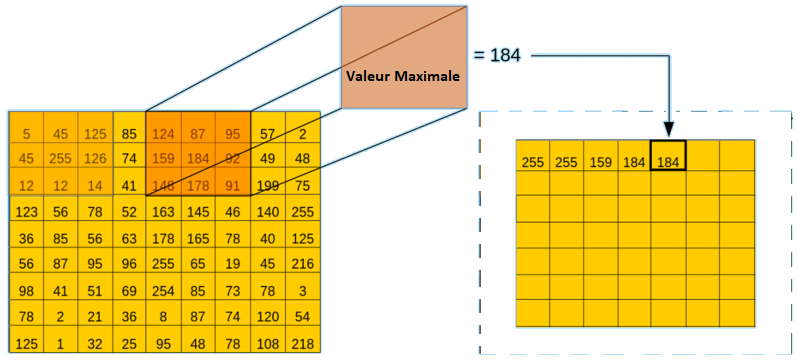

In [10]:
pil_im = Image.open(str(path_absolute)+'/img/pool.png')
display(pil_im)

- Les couches de déconvolution du décodeur

Le but des couches de déconvolution du décodeur implique de passer de données compressées vers un espace de plus grande taille desirée. Cela consiste à effectuer la "transposition des convolutions". 

Finalement, l'apprentissage de l'auto-encodeur s'effectue durant différentes phase de forward pass et backpropagation servant à modifier les valeurs des paramètres entraînables (étant les valeurs des différentes filtres de convolution et de déconvolution ainsi que les poids reliant chaque neurone ) en cherchant à minimiser la fonction de perte. 
Une fonction de perte relativement couramment utilisée est la MSE (Mean Squarred Error) qui consiste à minimiser la différence au carrée des images de sorties avec les images d'entrées. Ainsi : 
$$ MSE = \frac{1}{N}\sum_{i=1}^{N}(x_{i}-{\bar{x}i})^{2}$$

Néanmoins, les autoencodeurs possèdent un problème fondamental :pour la génération, l'espace latent convertit les entrées en vecteurs (encodés) qui peuvent ne pas être continus ou ne pas permettre une simple interpolation : les données de sorties ne peuvent pas différer des données d'entrées. C'est pourquoi nous allons préférer l'utilisation de "Variational AutoEncoders". 

## Explication d'un Variational Auto-Encodeur

Il nous a paru pertinent de faire un retour succint sur le fonctionnement des autoencodeurs, notamment sur les structures de l'encodeur et du décodeur dans le but de comprendre le fonctionnement et le paradigme quelque peu différent du variational-autoencodeur (VAE). 

Un VAE peut être défini comme étant un autoencodeur dont l'entraînement est régularisé pour évitter l'overfitting mais également s'assurer que l'espace latent possède des bonnes capacitées permettant un procédé de génération.
Effectivement, les VAEs ont une propriété fondamentale qui consiste à modéliser l'espace latent de telle sorte à ce qu'il soit continu : cela apporte de la stochasticité dans le réseau, lui permettant une meilleure généralisation.

(https://arxiv.org/abs/1312.6114)

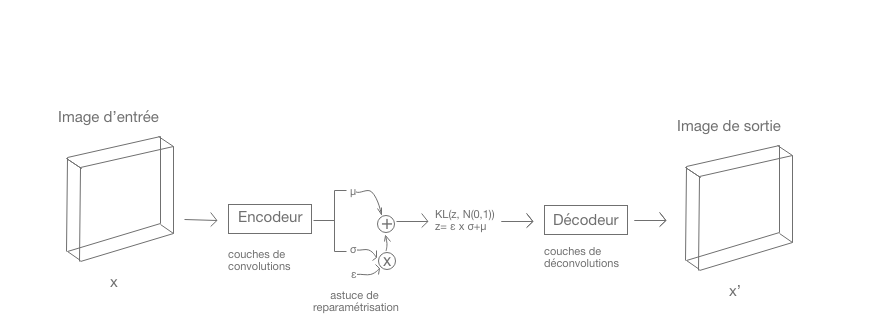

In [2]:
pil_im = Image.open(str(path_absolute)+'/img/variational_autoencoder.png')
display(pil_im)

_Schéma d'un Variational AutoEncodeur_

Comme pour un autoencodeur normal, l'autoencodeur est séparé en deux parties : 
- Un encodeur qui a pour but d'inférer de bonnes valeurs pour l'espace latent étant donné les données d'entrées : $p(z|x)$, avec x les données d'entrées et z l'espace latent. Cela se fait à travers différentes couches de convolutions. 
- Un décodeur, qui souhaite retrouver les données d'entrées sachant les valeurs de l'espace latent, soit $p(\bar{x}|z)$ avec $\bar{x}$ les données reconstruires, et z l'espace latent. Cela s'effectue normalement en modélisant le décodeur par des couches de déconvolutions. Nous verrons plus tard qu'il existe différents moyens de décoder les données : pour notre part, nous avons utilisé une technique s'appelant le "spatial broadcasting". 


La propriété du VAE se retrouve dans sa façon d'encoder l'espace latent. Au lieu de considérer directement la sortie des couches de convolutions de l'encodeur comme étant l'espace latent, le but est de récupérer cette sortie et de la séparer en deux vecteurs de taille n : un vecteur de moyenne $\mu$ et un vecteur d'écart-types $\sigma$. L'espace latent va alors être constitué d'un vecteur de taille que l'on détermine, constitué d'éléments échantillonnés à partir de la variable aléatoire X$\sim N(\mu ; \sigma^2)$. On va donc encoder les données d'entrées comme étant une distribution de probabilité dans l'espace latent. Cela force l'espace latent à être continu et stochastique, en permettant l'amélioration de l'interpolation dans l'espace latent ainsi que la généralisation du réseau. On va par la suite échantillonner des données depuis cette distribution et les passer dans le décodeur pour obtenir un terme d'erreur qui nous servira, de façon itérative, à mettre à jour les poids du réseau. 

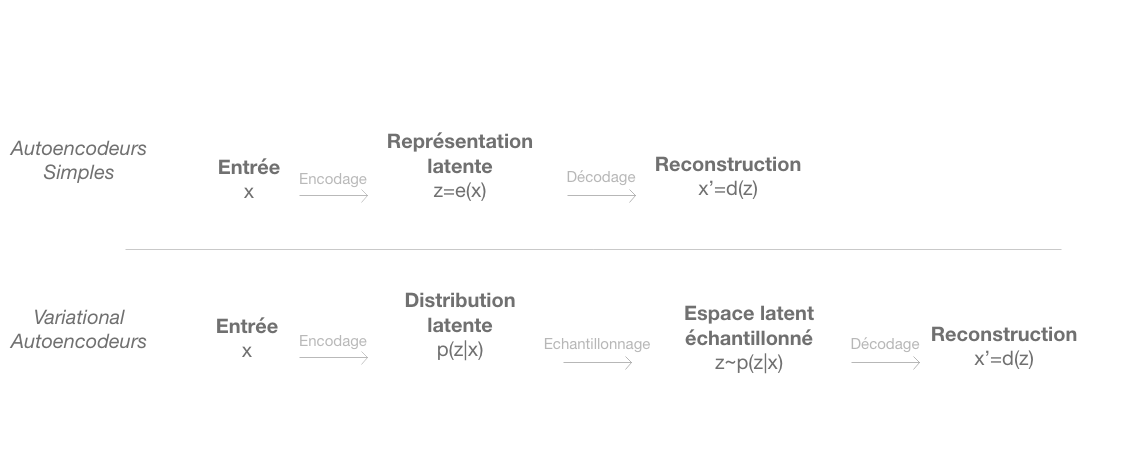

In [4]:
pil_im = Image.open(str(path_absolute)+'/img/schamevae.png')
display(pil_im)

Par ailleurs, la fonction de perte qui est minimisée durant l'entraînement du VAE est composée d'un "terme de reconstruction", dont le but est de rendre le schéma "encodage-décodage" le plus pertinent possible, et d'un "terme de régularisation", dont le but est de régulariser l'organisation de l'espace latent en faisant en sorte que la distribution de probabilité retournée par l'encodeur soit la plus proche possible d'une distribution normale. Pour ce terme de régulatisation, on utilise la Kullback-Leibler divergence (KL divergence) entre la distribution obtenue et une gaussienne normalisée.

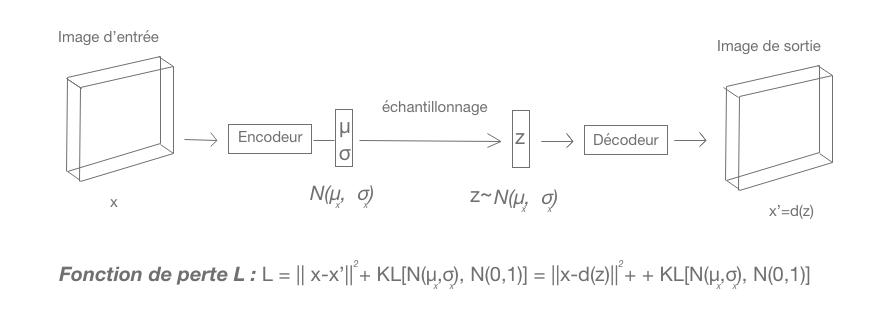

In [5]:
pil_im = Image.open(str(path_absolute)+'/img/loss.png')
display(pil_im)

Le seul fait que le VAE encode les entrées comme des distributions à la place de points n'est pas suffisant pour assurer la continuité et l'intégralité de l'espace latent. Sans le terme de régulatisation, le modèle peut apprendre dans le but de minimiser son erreur de reconstruction, d'ignorer le fait que des distributions sont retourner et agir presque comme un autoencodeur normal. Avec ce terme de régularisation, on empêche le modèle d'encoder les données loin les unes des autres dans l'espace latent, satisfaisant ainsi les conditions de continuité dt d'intégralité de l'espace latent. 

La fonction de perte, composée de la "négative log-likelihood" et du terme de régularisation peut s'écrire ainsi : 
$$li(θ,ϕ)=−E_{{z∼qθ}_{(z∣x_i)}}logp ϕ(x i∣z)+KL(q_θ(z∣x_i)∣∣p(z))$$
pour chaque donnée $x_i$. 
Effectivement, il n'y a pas de représentation globale partagée entre les données, on a alors pu la décomposer en termes ne dépendant que d'un seul point $x_i$.

Pour ce rapport, je ne m'attarderai pas plus dans les détails mathématiques, dont ce n'est pas le but.


## Impact de Beta sur l'apprentissage du réseau

(https://openreview.net/forum?id=Sy2fzU9gl)


L'architecture de β-VAE (Higgins et al., 2017) est une légère modification du VAE qui permet de mettre en évidence les facteurs désenmélés de l'espace lattent. De la même façon que le VAE, on souhaite maximiser la probabilité de générer les données observées, tout en gardant la distance entre la vraie distribution et celle estimée petite. On va ainsi ajouter un facteur β, appliquant ainsi un poids plus important sur la condition appliquée à l'espace latent. La fonction de perte devient alors : $$li(θ,ϕ)=−E_{{z∼qθ}_{(z∣x_i)}}logp ϕ(x i∣z)+βKL(q_θ(z∣x_i)∣∣p(z))$$
Ainsi, lorsque β=1, on retrouve l'architecture d'un simple VAE. Mais lorsque β>1, on applique une contrainte supplémentaire à l'espace latent, en limitant la capacité de représentation de z. Cela force alors le "démélage" de l'espace. Néanmoins, il est important de considérer que plus β augmente, moins le terme de reconstruction a d'impact lors de l'apprentissage : ainsi il est nécessaire de trouver une valeur de β qui permette à la fois une bonne reconstruction des données d'entrées ainsi qu'un espace latent démélé. 



## Explication du "Spatial Broadcasting"

(https://arxiv.org/abs/1901.07017)


Certains chercheurs de Deepmind avancent que l'utilisation des VAEs implique une difficulté pour le modèle d'exploiter les informations spatiales, lors de la phase de décodage. Ainsi, ils proposent une architecture différentes de simples couches de déconvolution pour le décodeur qui introduit un biais inductif pour les informations spatiales pouvant être utilisées lors de la génération : c'est ce qu'ils ont nommé le "spatial Brodcast Decoder". 
Pour obtenir cette architecture de décodeur, les différentes étapes sont les suivantes : 
- Dans un premier temps, il est nécessaire de concaténer l'espace latent de sorte à ce qu'il corresponde aux dimensions de l'image d'entrée.
- Ensuite, deux matrices de coordonnées horizontales et verticales sont générées avec les mêmes dimensions. Ces coordonnées sont indépendantes de l'images d'entrées, et sont choisies arbitrairement pour couvrir l'interval entre -1 et 1. 
- Ces deux matrices sont ensuite concaténées à l'espace latent augmenté, ce qui résulte à un volume 3D qui est ensuite passé dans des couches de convolutions. 

Ainsi, à la place d'utiliser une unique version de z pour savoir comment reconstruire l'image, "spatial broadcast decoder" renvoie plusieurs versions de cet espace, chacune rattachée à une localité spécifique sous la forme d'un volume 3D qui possède les mêmes dimensions que les données d'entrées. En utilisant du padding, le decodeur peut garder ces dimensions spatiales constantes et uniquement réduire le nombre de channels. Cela permet de faciliter la tache de reconstruction to en permettant au VAE d'apprendre des représentations démélées de l'espace latent. 


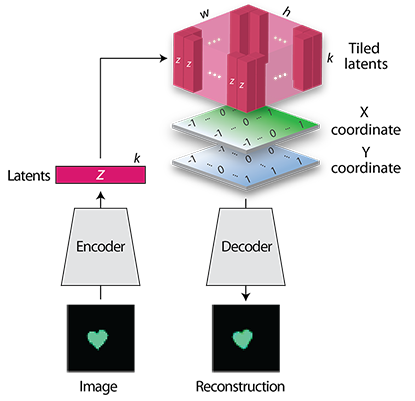

In [13]:
pil_im = Image.open(str(path_absolute)+'/img/spatialbroadcast.png')
display(pil_im)

## Entraînement du "spatial broadcast beta-VAE"

Pour cette première partie, nous avons implémenté un "SBD β-VAE" qui reprend l'ensemble des architectures présentées ci-dessus. Nous avons dans un premier temps importé les données nécessaire et créé un fichier CSV reprennant l'ensemble des chemins relatifs vers nos images créées avec Blender, associée pour chacune à son label correspondant (quaternion associé, dimensions de l'objet, nom de l'objet). Grâce à cela, nous avons créé un générateur permettant de créer un jeu de données d'entraînement et de test lors de l'apprentissage de notre réseau. Nous avons également implémenté l'architecture du réseau puis avons lancé l'apprentissage sur 300 epochs avant d'obtenir le résultat final.

### Importations des données

In [14]:
# don't display tensorflow warnings
import os, logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Load tensorboard for visualisation after training
%load_ext tensorboard
from dataset import *

#Reset of keras session
tf.keras.backend.clear_session()  

# Check of device used and tf version
print("Tensorflow version :", tf.__version__)
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Tensorflow version : 2.2.0
Please install GPU version of TF


La version de Tensorflow utilisée est bien la version 2.1.0, celle spécifiée dans les attentes du projet. De plus, Tensorflow tourne bien sur le GPU:0.

In [15]:
# import of usefull librairies
import glob
from dataset import *
import os
from os import path

# batch size for dataset creation
batch_size = 64
# relative path to dataset
data_dir =str(path_absolute)+ "/dataset/"
# creation of object dataset
dataset = DataSet(data_dir, batch_size)
# relative path to csv in order to create dataframe, if exist
csv_path = str(path_absolute)+"/dataframe_path_labels5.csv"

# creation of csv and dataframe for creating dataset
# check if csv exist, otherwise creation of csv file
if (path.exists(csv_path)):
    df = pd.read_csv(csv_path)
else: 
    df = dataset.create_csv(csv_path)
    
df.sample(frac=1)

,Path,Label
82916,/Users/jouffroy/Desktop/vae/dataset/sphe_3_1_1...,"{'filename': [False, False, False, False, Fals..."
126508,/Users/jouffroy/Desktop/vae/dataset/tore_trian...,"{'filename': [False, False, False, False, Fals..."
45650,/Users/jouffroy/Desktop/vae/dataset/parallelog...,"{'filename': [False, False, False, False, Fals..."
79210,/Users/jouffroy/Desktop/vae/dataset/sphe_2_1_1...,"{'filename': [False, False, False, False, Fals..."
7401,/Users/jouffroy/Desktop/vae/dataset/cone_1_1_1...,"{'filename': [False, False, False, False, Fals..."
...,...,...
70272,/Users/jouffroy/Desktop/vae/dataset/rectangle_...,"{'filename': [False, False, False, False, Fals..."
14896,/Users/jouffroy/Desktop/vae/dataset/cone_3_1_1...,"{'filename': [False, False, False, False, Fals..."
138316,/Users/jouffroy/Desktop/vae/dataset/triangle_r...,"{'filename': [False, False, False, False, Fals..."
58924,/Users/jouffroy/Desktop/vae/dataset/rectangle_...,"{'filename': [False, False, False, False, Fals..."


Nous avons pris la décision d'effectuer des batch de taille 64 ce qui nous paraissait être pertinent : suffisamment grand pour réduire le temps d'apprentissage, et suffisamment petit pour pouvoir allouer l'ensemble des données dans la mémoire. Du fait que nous utilisons un objet keras "ImageataGenerator" (c.f : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), et que nos labels consistent en différentes valeurs de différents types, il était nécessaire pour cela de créer un dataframe avec deux colonnes pour pouvoir récupérer convenablement nos données pour le générateur. Ainsi, le dataframe contient une colonne contenant le chematin relatif vers chacune des images du dataset, et la seconde colonne l'ensemble des labels associé à chaque image soit les dimensions sur les axes x,y et z ainsi que le type d'objet présent dans l'image et finalement le quaternion associé. 
Pour créer ce dataframe, nous avons récupéré l'ensemble des données que nous avions sauvegardées dans des fichiers .pkl. Il est possible à partir de cela de créer directement un dataframe, néanmoins nous avons pris la décision de d'abord créer un fichier csv qu'ensuite nous avons transformé en dataframe. Effectuer cela nous permettait de gagner du temps sur l'importation des données : en ne créant qu'une unique fois le csv, nous gagnos du temps par la suite pour récupérer nos données.
Par ailleurs, il était également nécessaire de décoder les données retranscrit dans le csv : les labels correspondent à une liste de données de type 'string'. Or nos quaternions et nos dimensions sont de type float. Ainsi, il était nécessaire de caster les données dans leur type de base correspondant.

In [6]:
# creation of generator of data
generator=dataset.create_generator(0.2,0.2,0.3,0.3)

# creationf of flow of data for training
train_data_gen = dataset.create_flow(generator, "training", df)
# creationf of flow of data for testing
test_data_gen = dataset.create_flow(generator, "validation", df)

# transformation of flow to Dataset tensorflow object for training
train_ds = tf.data.Dataset.from_generator(
    lambda: train_data_gen,
    output_types=(tf.float32, tf.string))

# transformation of flow to Dataset tensorflow object for testing
test_ds = tf.data.Dataset.from_generator(
    lambda: test_data_gen,
    output_types=(tf.float32, tf.string))

# caching and prefetching data for memory
train_data = dataset.prepare_for_training(train_ds)
test_data = dataset.prepare_for_training(test_ds)

Found 101602 validated image filenames.
Found 43543 validated image filenames.


Pour l'entraînement du VAE, nous avons pris la décision d'effectuer en temps réel des translations ainsi que des zooms sur nos images afin que l'apprentissage se fasse sur des objets qui couvrent l'ensemble de l'image de taille (128*128), et ainsi améliorer la généralisation. Ces translations et zooms s'effectuent de façon random grâce à la classe kera "ImageDataGenerator" en temps réel lors de l'appel du générateur. Par ailleurs, nous utilisons 30% du dataset complet pour la validation de l'apprentissage. Ainsi, on voit qu'il y a 100700 images dans le jeu d'entraînement et 43157 dans le jeu de test.  

In [9]:
# number of images in data_train (70% of all images)
train_size = train_data_gen.samples
# number of images in data_test (30% of images)
test_size = test_data_gen.samples
# number of batch in training set
batch_max_train = np.array(tf.floor(train_size/batch_size))
# number of batch in testing set
batch_max_test = np.array(tf.math.ceil(test_size/batch_size))


print("Number of images in train_dataset :", train_size)
print("Number of images on test dataset :", test_size)
print("Number of batch in training set : ", batch_max_train)
print("Number of batch in testing set : ", batch_max_test)

Number of images in train_dataset : 101602
Number of images on test dataset : 43543
Number of batch in training set :  1587.0
Number of batch in testing set :  681.0


Ainsi, en spécifiant que les batchs soient de taille 64, on observe que pour effectuer une epoch ( c'est à dire que pour que le réseau effectue une passe sur l'ensemble des images du dataset ),  il est nécessaire d'effectuer 1573 batchs pour couvrir le jeu d'apprentissage et 675 batchs pour couvrir le jeu d'entraînement. 

In [10]:
print(train_data)
print(test_data)

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.string)>
<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.string)>


On a souhaité ici avoir une vision plus précise des objets utilisés lors de l'apprentissage, c'est à dire de la structure du jeu de données et du jeu d'entraînement. Ainsi, on remarque que ces objets sont des objets tensorflow "PrefetchDataset", car effectivement nous avons prefetch les données afin de minimiser l'allocation mémoire. Ici, les shapes sont "unknown" car nous n'avons pas précisé la taille des tenseurs, mais en réalité ces objets sont de tailles (<image_shape>,<len(labels)>) soit (<128,128,1>,<1>),les labels étant de type 'string' nécessitant d'être décodés. 

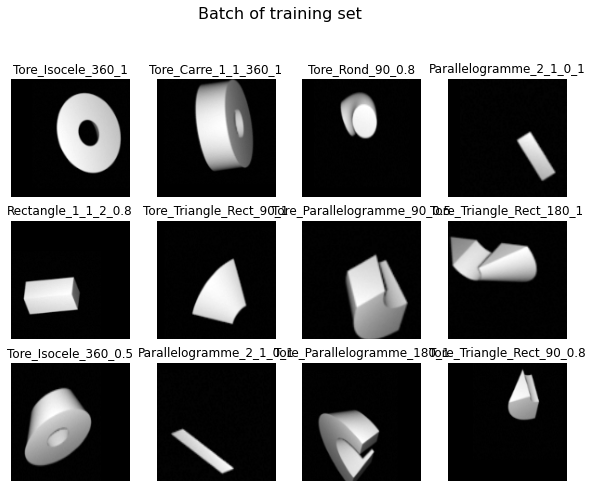

Valeur du pixel le plus élevé dans img_batch : 0.49803925
Valeur du pixel le moins élevé dans img_batch : 0.0


In [11]:
# getting next batch from training set for visualisation
image_batch, label_batch = next(iter(train_data))
dataset.show_batch(image_batch, label_batch)
print("Valeur du pixel le plus élevé dans img_batch :", np.array(image_batch).max())
print("Valeur du pixel le moins élevé dans img_batch :", np.array(image_batch).min())

On peut observer ci-dessus un exemple de douze images générées à partir d'un batch du jeu d'entraînement. Les images proviennent de celles générées par blender, à partir de fichiers STL. Elles ont été tirées aléatoirement de l'ensemble des 30% du jeu de données, et ont été en temps réél zoomées et/ou translatées sur l'axe des abscisses et/ou ordonnées. Dans l'ensemble de ce batch, dont les pixels ont été mis à l'échelle entre 0 et 1, la valeur minimale du pixel est 0 (ce qui est cohérent, le fond de chaque image étant noir ), et la valeur du pixel maximale étant 0.52, aucune image ne comprenant de blanc.  

### Sanity check: noise at one feedforward

Afin de s'assurer que le réseau soit correctement implémenté et qu'il puisse apprendre convenablement, il est nécessaire d'effectuer une certaine vérification : s'assurer que lorsque l'on passe un batch de données à travers le réseau, avant d'effectuer tout apprentissage, la sortie du réseau soit bien du bruit. Pour cela, nous allons passer la batch du jeu d'entraînement que l'on a visualisé ci-dessus, et le passer dans l'encodeur puis le décodeur, et afficher la moyenne de la distribution obtenue.

In [12]:
# creating an instance of the keras model
from variationalAutoEncoder import *

# beta used for elbo loss
beta = 1
# latent size for encoding
latent_size = 32
#shape of input images
image_shape = (128,128,1)
vae = VariationalAutoEncoder(latent_size,beta,image_shape)

# passing through encoder and decoder a batch of images
# without training to check the feedforward

approx_posterior = vae.encoder(image_batch)
print("approx_posterior : ", np.array(approx_posterior))

approx_posterior_sample = approx_posterior.sample()
print("latent sample shape: ", approx_posterior_sample.shape)

decoder_likelihood = vae.decoder(approx_posterior_sample)
print("decodeur likelihood", decoder_likelihood)

approx_posterior :  tfp.distributions.MultivariateNormalDiag("code", batch_shape=[64], event_shape=[32], dtype=float32)
latent sample shape:  (64, 32)
decodeur likelihood tfp.distributions.Independent("image", batch_shape=[64], event_shape=[128, 128, 1], dtype=float32)


On observe que la sortie de l'encodeur est bien une distribution normale multivariée, de taille (batch_size, latent_size). C'est à partir de cette distribution que nous allons échantillonner 32 élements qui forment notre espace latent, que nous allons ensuite décoder. Finalement, le décodeur, de taille (batch_size, image_shape) est bien une distribution normale indépendante pour chaque pixel. 

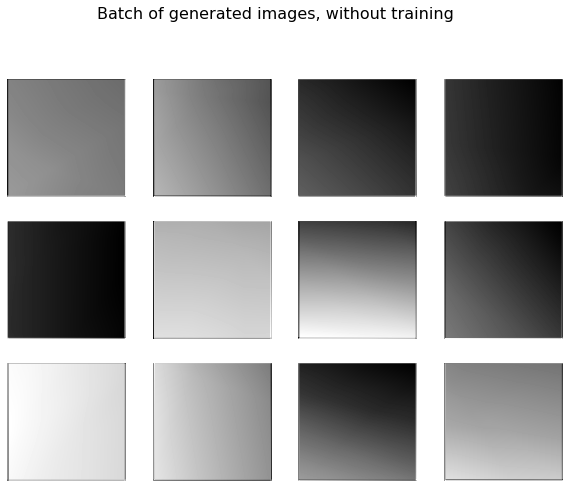

In [13]:
# get the mean of the ouput of the decoder in order 
# to plot the results without training
predictions = decoder_likelihood.mean()
fig = plt.figure(figsize=(10,10))
fig.suptitle('Batch of generated images, without training', fontsize=16)

for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

On observe qu'après cette première passe on obtient bien du bruit. Le réseau est alors bien initialisé, et capable d'apprendre correctement.

### Entraînement

Une fois les jeux d'entraînement et de test correctement implémentés afin de couvrir l'ensemble de l'espace, mais également après s'être assuré que le réseau était convenablement initialisé, nous pouvons passer à la partie d'entraînement nous permettant d'entraîner notre Variational Auto Encoder. 

In [14]:
# creating an instance of the class training
from trainig import *
# number of epoch for creation of dataset and training
epoch = 300

# Adam optimizer for training : Adam with 1e-3 
optimizer = tf.keras.optimizers.Adam(1e-3)

training = Training(vae, optimizer, batch_size, image_batch, batch_max_train, batch_max_test)

# checking a summaray of sequentials encoder and decoder,
# without the last distribution layer
vae.generative_net.summary()
vae.inference_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3684      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  6976      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  65        
Total params: 10,725
Trainable params: 10,725
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  320       
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  9248      
______________________________

Nous souhaitons effectuer notre entraînement sur 300 epochs, avec l'optimiseur "Adam" de learning rate 1e-3. En visualisant un récapitulatif des deux modèles que sont l'encodeur et le décodeur soient le modèle d'inférence et de génération qui constituent notre VAE, on observe que ces deux modèles sont de type "Sequential", c'est à dire une pile linéaire de couche de convolutions. Comme expliqué plus haut, le générateur n'est pas constitué de couches de déconvolutions pour reconstruire l'image car il est implémenté du "spatial broadcating". 
Ainsi, l'encodeur contient 327 200 paramètres et le décodeur 10 725, soient 337 925 paramètres qui doivent être mis à jours lors de la backpropagation du réseau afin de converger vers des paramètres pertinents pour les distributions de probabilités constituant l'espace latent et les valeurs des pixels des images générées. 

In [15]:
# train the network 

# comments line to run when training the network
##########################################################
#training.train(train_data, test_data, epoch, image_batch)
#vae.save_weights('./checkpoints/my_checkpoint/beta1')
##########################################################

Pour ce notebook, nous ne visualiserons pas la progression du modèle lors de l'apprentissage. Néanmoins, si vous souhaitez effectuer cela, il est nécessaire de décoder les lignes ci-dessus.

### Conclusion

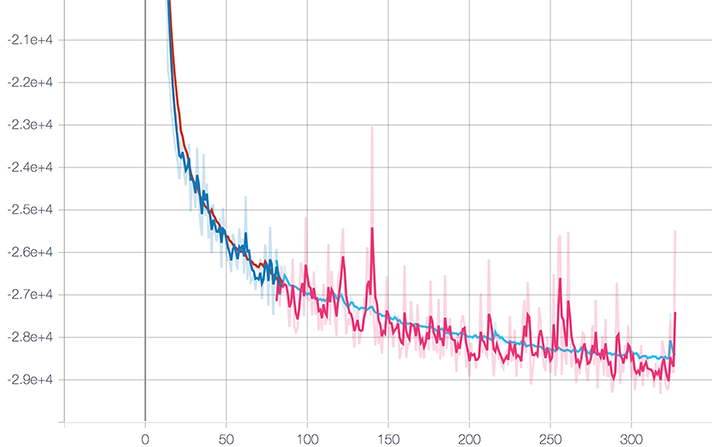

In [23]:
# open tensorboard to see data summaries

#comments line to run when training the network, to visualize metrics
# from tensorboard
##################################################
#%tensorboard --logdir logs/gradient_tape
##################################################
from IPython.display import display 
loss_img = Image.open(str(path_absolute)+"/img/loss1.png")
display(loss_img)

Lors de l'apprentissage, nous souhaitons minimiser l'inverse de la ELBO loss (ce qui revient à maximiser la ELBO). On peut observer ci-dessus une capture d'écran des résultats obtenus lors de notre apprentissage sur Tensorboard. Si vous souhaitez visualiser cela directement sur tensorboard après avior effectué l'entraînement, il est nécessaire de décommenter les lignes ci-dessus. 
Ainsi, la courbe bleue est la courbe d'apprentissage, et la rose la courbe de test. On observe bien que la perte diminue considérablement durant l'entraînement du modèle, et converge à partir de 300 epochs. (les courbes possèdent chacune deux couleurs différentes car l'entraînement s'est effectué sur deux fois).

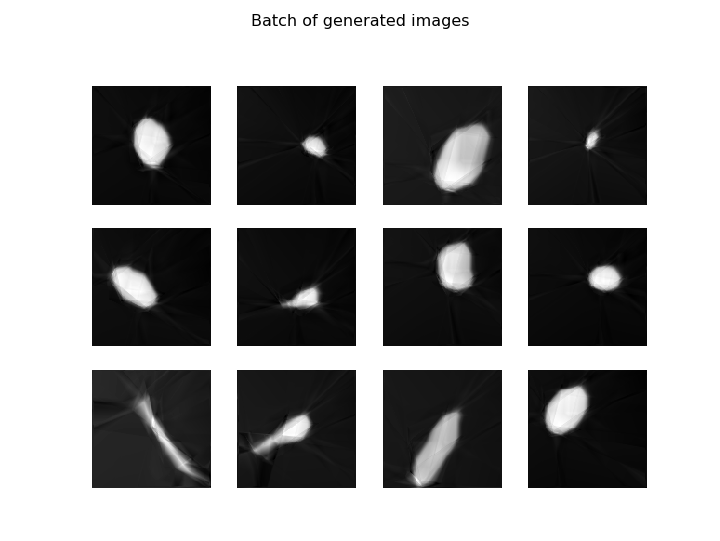

In [25]:
# displaying last image output when training the network
epoch300 = Image.open(str(path_absolute)+'/img/image_at_epoch_0300.png')
display(epoch300)

Finalement, voici un exemple d'images générées à partir du jeu d'entraînement une fois l'apprentissage du réseau terminé. On observe que lorsque beta = 1 (valeur utilisée ici lors de l'apprentissage), le réseau a convenablement appris l'emplacement des objets dans l'image ainsi que la taille de l'objet. Néanmoins, la forme exacte et la profondeur de l'objet n'ont pas été encodées. La deuxième étape du projet consiste à visualiser l'espace latent en faisant varier la valeur de béta, afin de vérifier l'impact de cette valeur sur le démélage de cet espace latent.